# dependencias

In [1]:
from youtube_transcript_api import YouTubeTranscriptApi
import youtube_dl
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
from itertools import combinations
import igraph as ig
import pandas as pd
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr
from math import log
import random
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Introduccion  

## 1.1 descipcion del caso, el numero de videos, palabras luedo de la limpieza 


# tokenizacion 

## 2.1 importacion del texto 

In [2]:
# leer los txt
with open('../input/caso_6.txt', 'r') as f:
    subtitulos_caso_6 = f.read()
with open('../input/caso_7_1.txt', 'r') as f:
    subtitulos_caso_7_lista1 = f.read()
with open('../input/caso_7_2.txt', 'r') as f:
    subtitulos_caso_7_lista2 = f.read()
with open('../input/caso_7_3.txt', 'r') as f:
    subtitulos_caso_7_lista3 = f.read()
subtitulos_caso_7 = '\n'.join([subtitulos_caso_7_lista1,subtitulos_caso_7_lista2,subtitulos_caso_7_lista3])

## 2.2 nomalizacion de los datos

### Funciones necesarias

In [3]:
def normalizacion_regex_texto(texto):
    # Eliminar caracteres o palabras entre [] y ()
    texto = re.sub(r'\[.*?\]', '', texto)
    texto = re.sub(r'\(.*?\)', '', texto)
    # eliminar letras individuales 
    texto = re.sub(r'\b\w\b', '', texto)
    # minimizar, limpieza de espacios, eliminacion de puntuacion  
    palabras = nltk.tokenize.word_tokenize(texto)
    palabras = [palabra.lower() for palabra in palabras if palabra.isalpha()]
    texto = ' '.join(palabras)
    # eliminar acentos o tildes
    texto = re.sub(r'[áéíóúÁÉÍÓÚ]', lambda x: 'aeiouAEIOU'['áéíóúÁÉÍÓÚ'.index(x.group(0))], texto)
    
    return texto

def contar_palabras_con_numeros(texto):
    # Encuentra todas las palabras que contienen al menos un número
    palabras_con_numeros = re.findall(r'\b\w*\d\w*\b', texto)
    
    # Inicializa un diccionario para el conteo de palabras
    conteo_palabras = {}
    
    # Itera sobre las palabras encontradas y cuenta cada una
    for palabra in palabras_con_numeros:
        if palabra in conteo_palabras:
            conteo_palabras[palabra] += 1
        else:
            conteo_palabras[palabra] = 1
    return conteo_palabras

def eliminar_texto_con_numeros(texto):
    texto = re.sub(r'\b\w*\d\w*\b', '', texto)
    return texto

def eliminar_stop_words(texto,stop_words):
    '''eliminar stopwords'''
    palabras = texto.split()
    palabras = [word for word in palabras if word not in stop_words]
    texto = ' '.join(palabras)
    return texto

### implementacion

In [4]:
# conteo de palabras
conteo_palabras_caso_6 = contar_palabras_con_numeros(subtitulos_caso_6[0])
# eliminar texto con numeros
subtitulos_caso_6= eliminar_texto_con_numeros(subtitulos_caso_6.replace('\n',' '))
# normalizar texto
subtitulos_caso_6 = normalizacion_regex_texto(subtitulos_caso_6)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()


subtitulos_caso_6 = eliminar_stop_words(subtitulos_caso_6,stop_words)

In [5]:
# conteo de palabras
conteo_palabras_caso_7 = contar_palabras_con_numeros(subtitulos_caso_7[0])
# eliminar texto con numeros
subtitulos_caso_7= eliminar_texto_con_numeros(subtitulos_caso_7.replace('\n',' '))
# normalizar texto
subtitulos_caso_7 = normalizacion_regex_texto(subtitulos_caso_7)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()
subtitulos_caso_7 = eliminar_stop_words(subtitulos_caso_7,stop_words)

In [6]:
print(len(subtitulos_caso_7),len(subtitulos_caso_6),sep='\n') # 6/7/7/7

3348267
1481860


## 2.3 analisis de frecuencias

### funciones necesarias

In [7]:
def plot_top_words(text, num_words=100, bar_color='blue', path_guardado=None):
    '''Genera un gráfico de barras con las palabras más comunes en un texto luego de ser limpiado y tokenizado.'''
    # separar el texto en palabras
    words = text.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)

    # Obtener las palabras más comunes
    top_words = word_freq.most_common(num_words)

    # Preparar datos para el gráfico
    words, freq = zip(*top_words)
    
    # Crear el gráfico de barras con el color especificado
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(words)), freq, align='center', color=bar_color)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()  # Invertir el eje y para que las palabras más comunes estén en la parte superior
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.title(f'Top {num_words} palabras más usadas')
    plt.savefig(path_guardado) # Guardar el gráfico antes de mostrarlo
    plt.show()


def plot_wordcloud(text, max_words=10, color='Accent',path_guardado=None):
    # Genera un contador de las palabras en el texto
    word_counts = Counter(text.split())

    # Obtiene las 'max_words' palabras más comunes
    most_common_words = dict(word_counts.most_common(max_words))

    # Genera la nube de palabras con un solo color
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate_from_frequencies(most_common_words)

    # Crea la figura de Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(path_guardado) # Guardar el gráfico antes de mostrarlo
    plt.show()

# Ahora deberías poder guardar correctamente las imágenes.

### implementacion

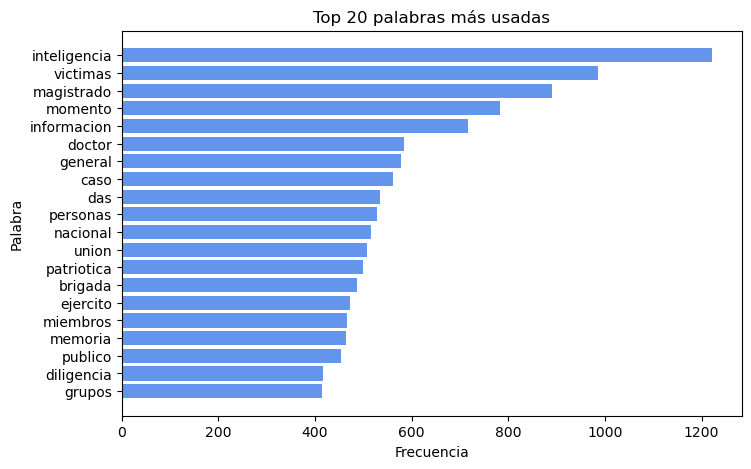

In [8]:
plot_top_words(subtitulos_caso_6,20,'cornflowerblue',path_guardado='../output/taller4_plot/caso_6/palabras_frecuentes_caso_6.png')

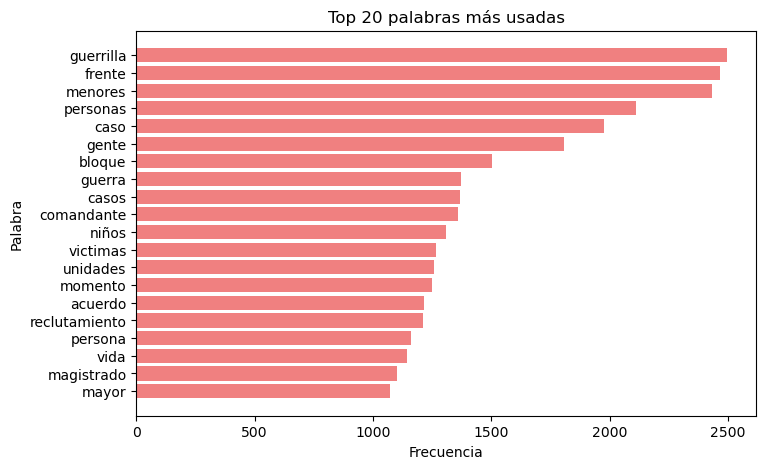

In [9]:
plot_top_words(subtitulos_caso_7,20,'lightcoral',path_guardado='../output/taller4_plot/caso_7/palabras_frecuentes_caso_7.png')

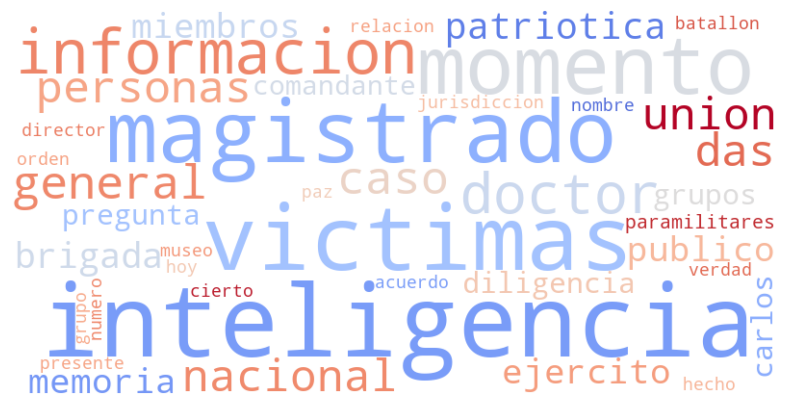

In [10]:
plot_wordcloud(subtitulos_caso_6, max_words=40, color= 'coolwarm',path_guardado='../output/taller4_plot/caso_6/wordcloud_caso_6.png')

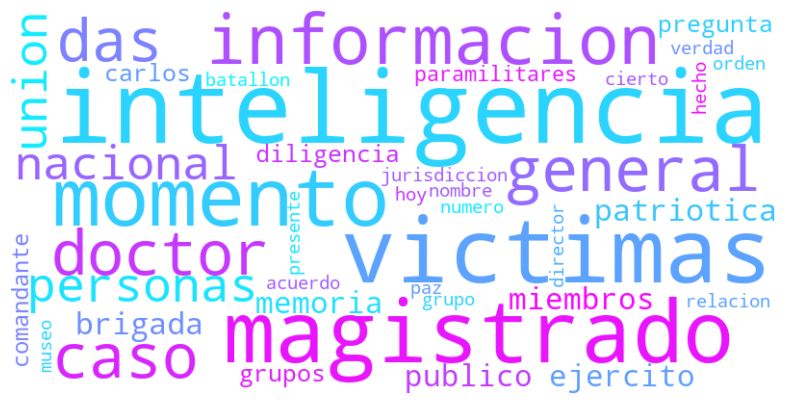

In [11]:
plot_wordcloud(subtitulos_caso_6, max_words=40, color='cool',path_guardado='../output/taller4_plot/caso_7/wordcloud_caso_7.png')

## 2.5 Correlacion de entre los casos

### funciones necesarias

In [12]:
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm

def contar_apariciones(str1, str2):
    return _contar_apariciones_general(str1, str2)

def contar_apariciones_dos_textos(str1, str2):
    return _contar_apariciones_general(str1, str2, common_only=True)

def _contar_apariciones_general(str1, str2, common_only=False):
    # Dividir las cadenas en palabras y convertirlas a minúsculas para evitar distinción entre mayúsculas y minúsculas
    palabras_str1 = str1.lower().split()
    palabras_str2 = str2.lower().split()
    
    # Contar las apariciones de palabras en cada cadena
    contador_str1 = Counter(palabras_str1)
    contador_str2 = Counter(palabras_str2)
    
    # Obtener un conjunto único de todas las palabras
    palabras_totales = set(palabras_str1).union(set(palabras_str2))
    
    # Si solo queremos palabras comunes, utilizar intersección en lugar de unión
    if common_only:
        palabras_totales = set(palabras_str1).intersection(set(palabras_str2))
    
    # Inicializar un diccionario para contar las apariciones de cada palabra en cada cadena
    contador = defaultdict(lambda: {'Frecuencia en str1': 0, 'Frecuencia en str2': 0})
    for palabra in tqdm(palabras_totales, desc="Procesando palabras"):
        contador[palabra]['Frecuencia en str1'] = contador_str1[palabra] / len(palabras_str1)
        contador[palabra]['Frecuencia en str2'] = contador_str2[palabra] / len(palabras_str2)
    
    # Crear DataFrame
    df = pd.DataFrame.from_dict(contador, orient='index').reset_index()
    df.columns = ['Palabra', 'Frecuencia en str1', 'Frecuencia en str2']
    
    return df

### implementacion

In [13]:
resultado_1 = contar_apariciones(subtitulos_caso_6, subtitulos_caso_7)
# Usar la función contar_apariciones_dos_textos
resultado_2 = contar_apariciones_dos_textos(subtitulos_caso_6, subtitulos_caso_7)


Procesando palabras: 100%|██████████| 10661/10661 [00:00<00:00, 443812.84it/s]


In [14]:
resultado_1.sort_values('Frecuencia en str1', ascending=False).head(20)


,Palabra,Frecuencia en str1,Frecuencia en str2
20927,inteligencia,0.006977,0.000499
1324,victimas,0.005629,0.003207
3094,magistrado,0.005081,0.002787
12419,momento,0.004470,0.003164
13992,informacion,0.004088,0.002519
9053,doctor,0.003334,0.001408
14972,general,0.003300,0.001235
17206,caso,0.003209,0.005002
29798,das,0.003049,0.000028
19047,personas,0.003015,0.005349


In [15]:
resultado_2.sort_values('Frecuencia en str2', ascending=False).head(10)


,Palabra,Frecuencia en str1,Frecuencia en str2
1492,guerrilla,0.000360,0.006316
1270,frente,0.001484,0.006240
405,menores,0.000029,0.006159
4597,personas,0.003015,0.005349
2161,caso,0.003209,0.005002
8987,gente,0.001039,0.004577
4370,bloque,0.000560,0.003800
1119,guerra,0.000657,0.003473
4914,casos,0.000708,0.003461
1204,comandante,0.002107,0.003443


In [16]:
# test de correlacion de pearson
correlation_coefficient, p_value = pearsonr(resultado_2['Frecuencia en str1'], resultado_2['Frecuencia en str2'])

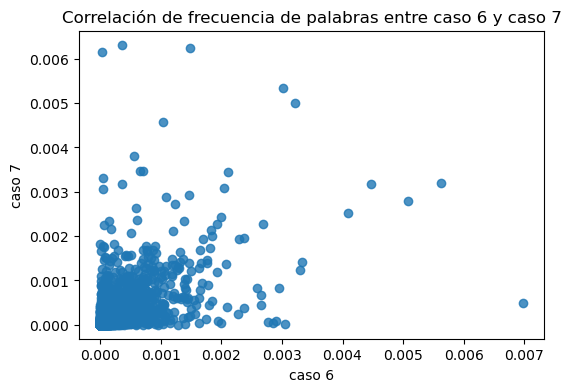

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=resultado_2['Frecuencia en str1'], y=resultado_2['Frecuencia en str2'], alpha= 0.8)
ax.set_xlabel('caso 6')
ax.set_ylabel('caso 7')
#añadimos titulo 
plt.title('Correlación de frecuencia de palabras entre caso 6 y caso 7')
# guardar imagen
plt.savefig('../output/taller4_plot/correlacion.png')


# 4.Bigramas y analisis de grafos

## 4.1 frecuencias

### Funciones 


In [18]:
def Generacion_de_skipgramas(text, n_palabras, k_saltos):
    '''Genera skipgrams de un texto dado con un tamaño de ventana n y un número de skips k.'''
    # Tokenize words
    words = nltk.word_tokenize(text)
    
    # Initialize list to store skipgrams
    skipgrams_list = []
    
    # Generate skipgrams
    for i in range(len(words)):
        # Create combinations of words with skips
        skipgrams = combinations(words[i:i+n_palabras+k_saltos], n_palabras)
        skipgrams_list.extend(skipgrams)
    
    return skipgrams_list

def plot_bigramas(skipgramas, top_n=10,path_guardado=None):
    # Convertir los bigramas a tuplas ordenadas alfabéticamente
    skipgramas_ordenados = [tuple(sorted(bigram)) for bigram in skipgramas]
    
    # Conteo de bigramas
    conteo_bigramas = Counter(skipgramas_ordenados)

    # Obtener los N bigramas más frecuentes
    bigramas_mas_frecuentes = conteo_bigramas.most_common(top_n)

    # Obtener datos para el gráfico
    bigramas_unicos = [bigrama[0] for bigrama in bigramas_mas_frecuentes]
    frecuencias = [frecuencia for _, frecuencia in bigramas_mas_frecuentes]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(bigramas_unicos)), frecuencias, tick_label=[f"{bigrama[0]} {bigrama[1]}" for bigrama in bigramas_unicos])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Bigramas')
    plt.ylabel('Frecuencia')
    plt.title(f'Top {top_n} Bigramas más Frecuentes')
    plt.savefig(path_guardado, bbox_inches='tight')
    plt.show()

### implementacion

In [19]:
skipgrams_caso_6 = Generacion_de_skipgramas(subtitulos_caso_6, n_palabras=2, k_saltos=1)
skipgrams_caso_7 = Generacion_de_skipgramas(subtitulos_caso_7, n_palabras=2, k_saltos=1)

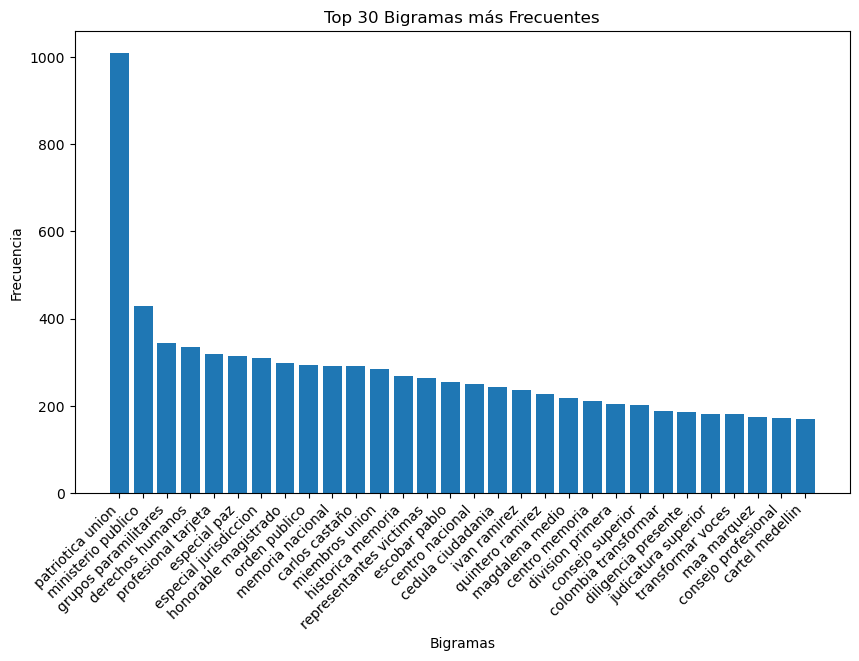

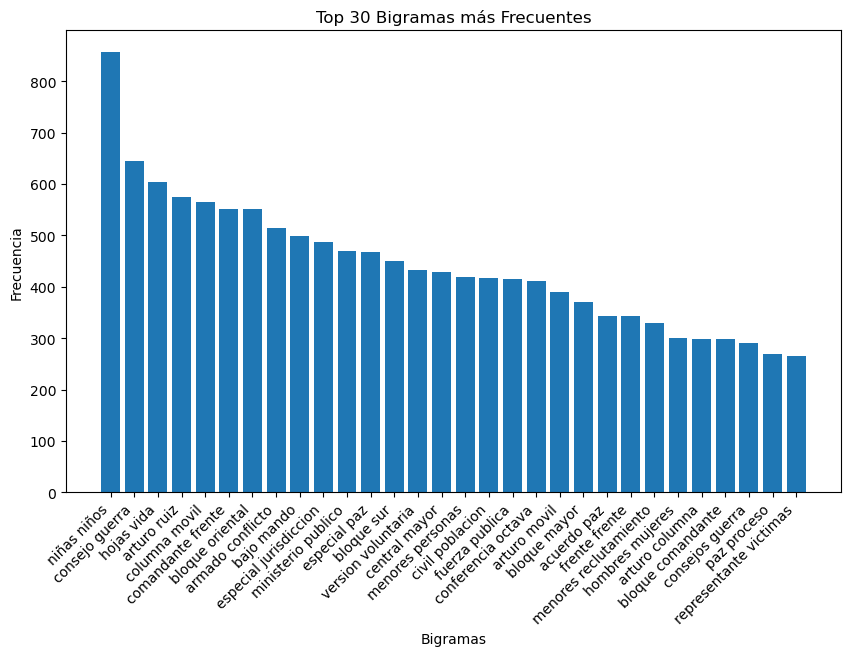

In [20]:
plot_bigramas(skipgrams_caso_6,30,path_guardado='../output/taller4_plot/caso_6/bigramas_caso_6.png')
plot_bigramas(skipgrams_caso_7,30,path_guardado='../output/taller4_plot/caso_7/bigramas_caso_7.png')

## 4.2 grafo bajo umbral 

### funciones


In [21]:
def frecuencia_bigramas(lista_bigramas, umbral):
    # Utilizamos Counter para contar las ocurrencias de las tuplas en la lista
    lista_bigramas = [tuple(sorted(tupla)) for tupla in lista_bigramas]
    contador = Counter(lista_bigramas)
    
    # Filtramos las tuplas que tienen una frecuencia mayor que el umbral
    tuplas_filtradas = [(tupla , frecuencia)for tupla, frecuencia in contador.items() if frecuencia > umbral]
    
    return tuplas_filtradas

def bigramas_para_grafo(lista_bigramas, umbral=10):
    # Utilizamos Counter para contar las ocurrencias de las tuplas en la lista
    lista_bigramas = [tuple(sorted(tupla)) for tupla in lista_bigramas]
    contador = Counter(lista_bigramas)
    
    # Filtramos las tuplas que tienen una frecuencia mayor que el umbral
    tuplas_filtradas = [(tupla ,frecuencia)for tupla, frecuencia in contador.items() if frecuencia > umbral]
    
    return tuplas_filtradas

def creacion_del_grafo(aristas):
    # Crear un grafo
    G = ig.Graph()

    # Conjunto de nodos existentes
    nodos_existentes = set()

    # Añadir las aristas al grafo
    for arista, peso in aristas:
        nodo1, nodo2 = arista

        if nodo1 != nodo2: 

            # Verificar si los nodos ya existen
            if nodo1 not in nodos_existentes:
                G.add_vertex(nodo1)  # Agregar vértice origen
                nodos_existentes.add(nodo1)  # Agregar nodo al conjunto de nodos existentes
            if nodo2 not in nodos_existentes:
                G.add_vertex(nodo2)  # Agregar vértice destino
                nodos_existentes.add(nodo2)  # Agregar nodo al conjunto de nodos existentes

            # Agregar arista con peso
            G.add_edge(nodo1, nodo2, weight=peso)

    return G

### implementacion 

grafo con umbral alto 

In [22]:
bigramas_para_grafos_caso_6 = bigramas_para_grafo(skipgrams_caso_6,60)
bigramas_para_grafos_caso_7 = bigramas_para_grafo(skipgrams_caso_7,100)

In [23]:
print(len(bigramas_para_grafos_caso_6),len(bigramas_para_grafos_caso_7))

165 175


In [24]:
G_caso_6 = creacion_del_grafo(bigramas_para_grafos_caso_6)
G_caso_7 = creacion_del_grafo(bigramas_para_grafos_caso_7)

#### grafo caso 6

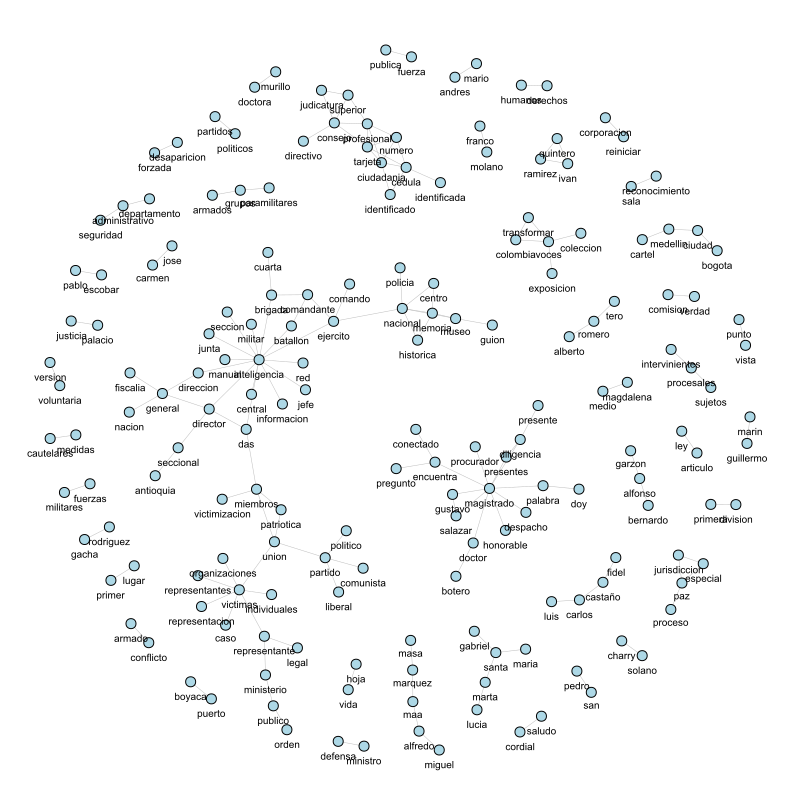

In [25]:
import math
layout_caso_6 = G_caso_6.layout("fr")
# estadistica de la red
nombres_nodos = G_caso_6.vs["name"]  # Obtener los nombres de los nodos

# Calcular las métricas
grado_promedio = G_caso_6.average_path_length()
nodo_con_mayor_grado = nombres_nodos[G_caso_6.degree().index(max(G_caso_6.degree()))]
# mayor grado
grado = max(G_caso_6.degree())
fuerza = np.mean(G_caso_6.strength(weights=G_caso_6.es['weight']))
nodo_mas_importante_betweenness = nombres_nodos[G_caso_6.betweenness().index(max(G_caso_6.betweenness()))]
densidad = G_caso_6.density()
transitividad_global = G_caso_6.transitivity_undirected()
#
transitividad_local = np.mean([x for x in G_caso_6.transitivity_local_undirected() if not math.isnan(x)])

# Organizar los resultados en un DataFrame de pandas
df_caso_6 = pd.DataFrame({
    'Métrica': ['Grado Promedio','Grado', 'Nodo con Mayor Grado', 'Fuerza', 'Nodo Más Importante (Betweenness)', 'Densidad', 'Transitividad Global','transitividad_local'],
    'Valor': [grado_promedio,grado, nodo_con_mayor_grado, fuerza, nodo_mas_importante_betweenness, densidad, transitividad_global,transitividad_local]
})

# graficar
ig.plot(G_caso_6,'../output/taller4_plot/caso_6/caso6_completo.png', layout=layout_caso_6, bbox=(800, 800),vertex_label = G_caso_6.vs['name'], margin=50,vertex_size=10,vertex_label_size=10,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')


In [26]:
df_caso_6.to_latex('../output/taller4_plot/caso_6/metricas_caso_6.tex', index=False)

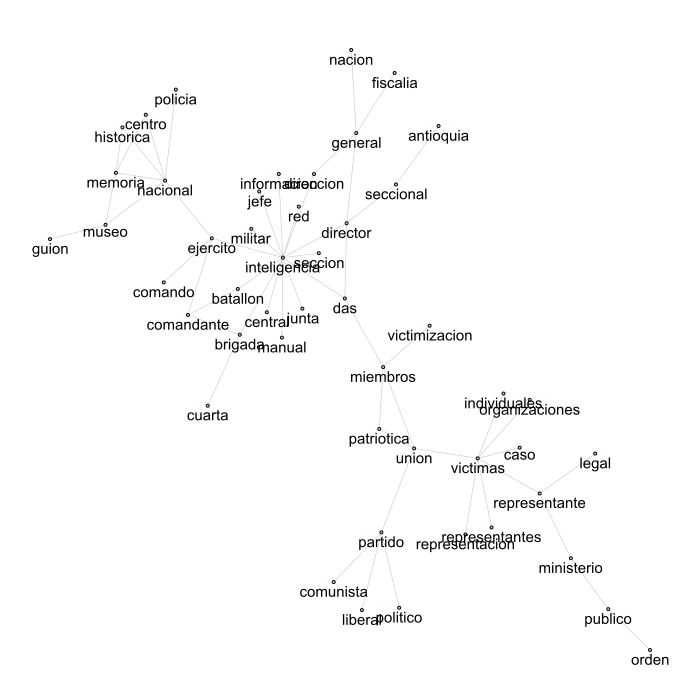

In [27]:
# sacar componente gigante
G_caso_6_gigante = G_caso_6.connected_components().giant()
layout_gigante_6 = G_caso_6_gigante.layout("kk")
# Calcular la suma de los pesos de las aristas para cada nodo
sum_pesos_aristas = G_caso_6_gigante.strength(weights='weight')

# Normalizar la suma de los pesos de las aristas para ajustarla al rango de tamaños de los nodos
max_sum_pesos_aristas = max(sum_pesos_aristas)
sizes = [x / max_sum_pesos_aristas * 40 for x in sum_pesos_aristas]  # Ajusta el rango de tamaño deseado
G_caso_6_gigante.vs["size"] = sizes

ig.plot(G_caso_6_gigante,'../output/taller4_plot/caso_6/compnente_gigante_6.png', layout=layout_gigante_6, bbox=(700, 700), margin=50,vertex_size=3,vertex_label_size=15,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=G_caso_6_gigante.vs['name'],vertex_color='lightblue',edge_color='gray')

In [28]:
nombres_nodos = G_caso_6_gigante.vs["name"]  # Obtener los nombres de los nodos

# Calcular las métricas
grado_promedio = G_caso_6_gigante.average_path_length()
nodo_con_mayor_grado = nombres_nodos[G_caso_6_gigante.degree().index(max(G_caso_6_gigante.degree()))]
# mayor grado
grado = max(G_caso_6_gigante.degree())
fuerza = np.mean(G_caso_6_gigante.strength(weights=G_caso_6_gigante.es['weight']))
nodo_mas_importante_betweenness = nombres_nodos[G_caso_6_gigante.betweenness().index(max(G_caso_6_gigante.betweenness()))]
densidad = G_caso_6_gigante.density()
transitividad_global = G_caso_6_gigante.transitivity_undirected()
#
transitividad_local = np.mean([x for x in G_caso_6_gigante.transitivity_local_undirected() if not math.isnan(x)])

# Organizar los resultados en un DataFrame de pandas
df_caso_6_gigante = pd.DataFrame({
    'Métrica': ['Grado Promedio','Grado', 'Nodo con Mayor Grado', 'Fuerza', 'Nodo Más Importante (Betweenness)', 'Densidad', 'Transitividad Global','transitividad_local'],
    'Valor': [grado_promedio,grado, nodo_con_mayor_grado, fuerza, nodo_mas_importante_betweenness, densidad, transitividad_global,transitividad_local]
})

In [29]:
df_caso_6_gigante.to_latex('../output/taller4_plot/caso_6/metricas_caso_6_gigante.tex', index=False)

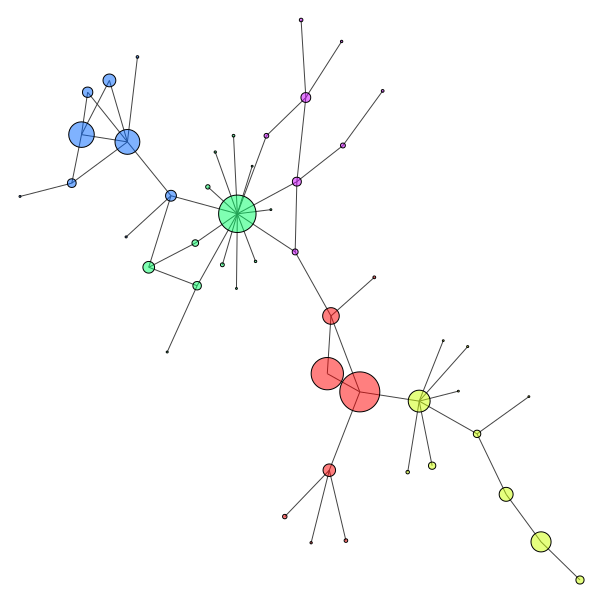

In [30]:
dendrogram = G_caso_6_gigante.community_edge_betweenness()

# Obtener las comunidades finales
communities = dendrogram.as_clustering()

# Obtener el número de comunidades
num_communities = len(communities)

# Asignar colores a cada comunidad
palette = ig.RainbowPalette(n=num_communities)
community_colors = [palette.get(i) for i in communities.membership]

# Definir transparencia para los nodos
node_transparency = 0.5  # Valor entre 0 y 1, donde 0 es completamente transparente y 1 es completamente opaco

# Convertir los colores de las comunidades a RGBA con la transparencia deseada
community_colors_with_alpha = [color[:-1] + (node_transparency,) for color in community_colors]

# Dibujar el grafo con nodos semi-transparentes
ig.plot(G_caso_6_gigante,'../output/taller4_plot/caso_6/comunidades_6.png', layout=layout_gigante_6,vertex_color=community_colors_with_alpha)

In [31]:
for community_id in range(num_communities):
    # Obtener los nodos de la comunidad actual
    community_nodes = [node for node, membership in enumerate(communities.membership) if membership == community_id]
    
    # Calcular el grado de cada nodo en la comunidad
    node_degrees = [G_caso_6_gigante.degree(node) for node in community_nodes]
    
    # Encontrar el nodo con el mayor grado
    node_with_max_degree_index = node_degrees.index(max(node_degrees))
    node_with_max_degree = community_nodes[node_with_max_degree_index]
    
    # Obtener la palabra asociada al nodo con el mayor grado
    most_connected_word = G_caso_6_gigante.vs[node_with_max_degree]['name']
    
    # Imprimir la palabra más importante de la comunidad actual
    print(f"Comunidad {community_id}: Palabra más importante (según grado): {most_connected_word}")

Comunidad 0: Palabra más importante (según grado): miembros
Comunidad 1: Palabra más importante (según grado): victimas
Comunidad 2: Palabra más importante (según grado): inteligencia
Comunidad 3: Palabra más importante (según grado): nacional
Comunidad 4: Palabra más importante (según grado): director


#### Grafo caso 7

In [32]:
# grafico de red
# "auto","kk","fr","grid_fr","lgl","rt","circle","shell","spring","spectral"
# Calcular las métricas
nombres_nodos = G_caso_7.vs["name"]  # Obtener los nombres de los nodos

# Calcular las métricas
grado_promedio = G_caso_7.average_path_length()
nodo_con_mayor_grado = nombres_nodos[G_caso_7.degree().index(max(G_caso_7.degree()))]
# mayor grado
grado = max(G_caso_7.degree())
fuerza = np.mean(G_caso_7.strength(weights=G_caso_7.es['weight']))
nodo_mas_importante_betweenness = nombres_nodos[G_caso_7.betweenness().index(max(G_caso_7.betweenness()))]
densidad = G_caso_7.density()
transitividad_global = G_caso_7.transitivity_undirected()
#
transitividad_local = np.mean([x for x in G_caso_7.transitivity_local_undirected() if not math.isnan(x)])

# Organizar los resultados en un DataFrame de pandas
df_caso_7 = pd.DataFrame({
    'Métrica': ['Grado Promedio','Grado', 'Nodo con Mayor Grado', 'Fuerza', 'Nodo Más Importante (Betweenness)', 'Densidad', 'Transitividad Global','transitividad_local'],
    'Valor': [grado_promedio,grado, nodo_con_mayor_grado, fuerza, nodo_mas_importante_betweenness, densidad, transitividad_global,transitividad_local]
})
layout_caso_7 = G_caso_7.layout("fr")


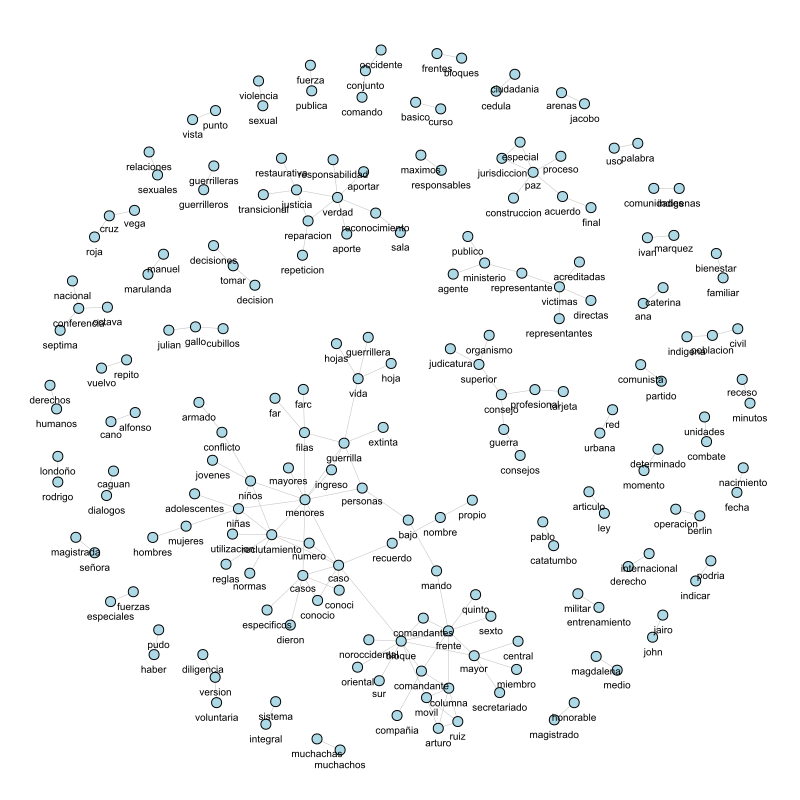

In [33]:
ig.plot(G_caso_7,'../output/taller4_plot/caso_7/caso7_completo.png', layout=layout_caso_7, bbox=(800, 800),vertex_label =  G_caso_7.vs['name'], margin=50,vertex_size=10,vertex_label_size=10,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')

In [34]:
df_caso_7.to_latex('../output/taller4_plot/caso_7/metricas_caso_7.tex', index=False)

compenente gigante 


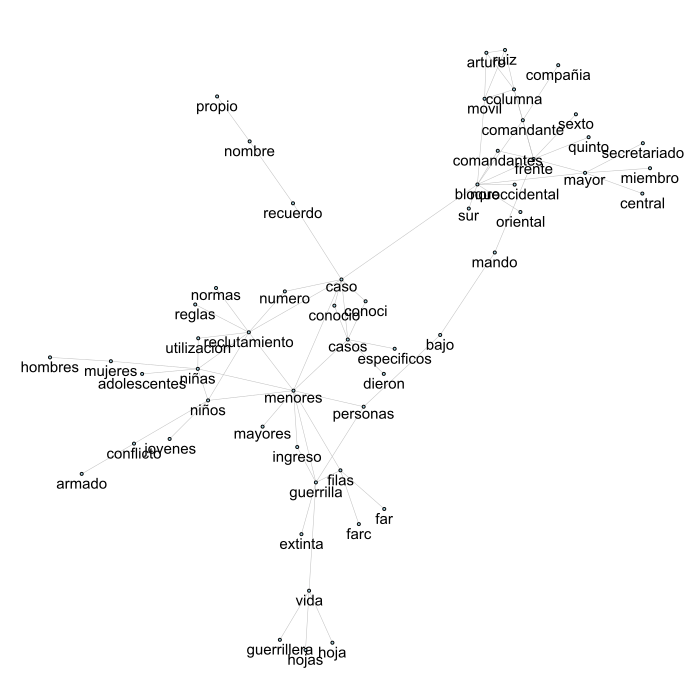

In [35]:
# sacar componente gigante
G_caso_7_gigante = G_caso_7.connected_components().giant()
layout_gigante_7 = G_caso_7_gigante.layout("fr")
# Calcular la suma de los pesos de las aristas para cada nodo
sum_pesos_aristas = G_caso_7_gigante.strength(weights='weight')

# Normalizar la suma de los pesos de las aristas para ajustarla al rango de tamaños de los nodos
max_sum_pesos_aristas = max(sum_pesos_aristas)
sizes = [x / max_sum_pesos_aristas * 40 for x in sum_pesos_aristas]  # Ajusta el rango de tamaño deseado
G_caso_7_gigante.vs["size"] = sizes

ig.plot(G_caso_7_gigante,'../output/taller4_plot/caso_7/compnente_gigante_7.png', layout=layout_gigante_7, bbox=(700, 700), margin=50,vertex_size=3,vertex_label_size=15,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=G_caso_7_gigante.vs['name'],vertex_color='lightblue',edge_color='gray')

In [36]:
nombres_nodos = G_caso_7_gigante.vs["name"]  # Obtener los nombres de los nodos

# Calcular las métricas
grado_promedio = G_caso_7_gigante.average_path_length()
nodo_con_mayor_grado = nombres_nodos[G_caso_7_gigante.degree().index(max(G_caso_7_gigante.degree()))]
# mayor grado
grado = max(G_caso_7_gigante.degree())
fuerza = np.mean(G_caso_7_gigante.strength(weights=G_caso_7_gigante.es['weight']))
nodo_mas_importante_betweenness = nombres_nodos[G_caso_7_gigante.betweenness().index(max(G_caso_7_gigante.betweenness()))]
densidad = G_caso_7_gigante.density()
transitividad_global = G_caso_7_gigante.transitivity_undirected()
#
transitividad_local = np.mean([x for x in G_caso_7_gigante.transitivity_local_undirected() if not math.isnan(x)])

# Organizar los resultados en un DataFrame de pandas
df_caso_7_gigante = pd.DataFrame({
    'Métrica': ['Grado Promedio','Grado', 'Nodo con Mayor Grado', 'Fuerza', 'Nodo Más Importante (Betweenness)', 'Densidad', 'Transitividad Global','transitividad_local'],
    'Valor': [grado_promedio,grado, nodo_con_mayor_grado, fuerza, nodo_mas_importante_betweenness, densidad, transitividad_global,transitividad_local]})

df_caso_7_gigante.to_latex('../output/taller4_plot/caso_7/metricas_caso_7_gigante.tex', index=False)

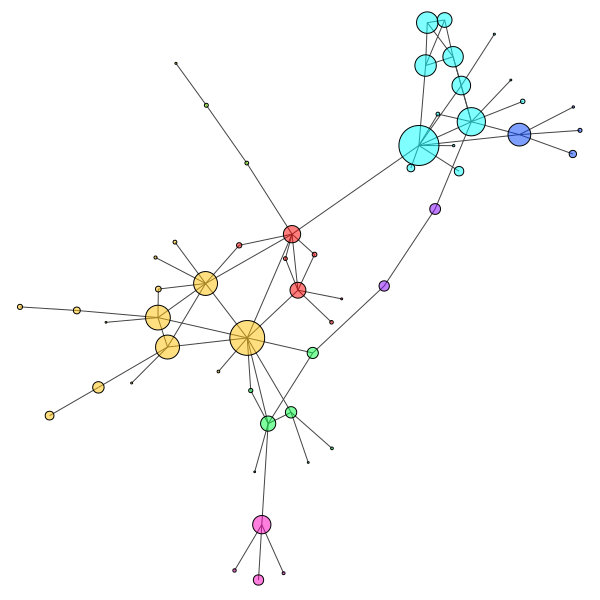

In [37]:
dendrogram = G_caso_7_gigante.community_edge_betweenness()

# Obtener las comunidades finales
communities = dendrogram.as_clustering()

# Obtener el número de comunidades
num_communities = len(communities)

# Asignar colores a cada comunidad
palette = ig.RainbowPalette(n=num_communities)
community_colors = [palette.get(i) for i in communities.membership]

# Definir transparencia para los nodos
node_transparency = 0.5  # Valor entre 0 y 1, donde 0 es completamente transparente y 1 es completamente opaco

# Convertir los colores de las comunidades a RGBA con la transparencia deseada
community_colors_with_alpha = [color[:-1] + (node_transparency,) for color in community_colors]

# Dibujar el grafo con nodos semi-transparentes
ig.plot(G_caso_7_gigante,'../output/taller4_plot/caso_7/comunidades_7.png', layout=layout_gigante_7,vertex_color=community_colors_with_alpha)


In [38]:
# Recorre cada comunidad
for community_id in range(num_communities):
    # Obtener los nodos de la comunidad actual
    community_nodes = [node for node, membership in enumerate(communities.membership) if membership == community_id]
    
    # Calcular el grado de cada nodo en la comunidad
    node_degrees = [G_caso_7_gigante.degree(node) for node in community_nodes]
    
    # Encontrar el nodo con el mayor grado
    node_with_max_degree_index = node_degrees.index(max(node_degrees))
    node_with_max_degree = community_nodes[node_with_max_degree_index]
    
    # Obtener la palabra asociada al nodo con el mayor grado
    most_connected_word = G_caso_7_gigante.vs[node_with_max_degree]['name']
    
    # Imprimir la palabra más importante de la comunidad actual
    print(f"Comunidad {community_id}: Palabra más importante (según grado): {most_connected_word}")



Comunidad 0: Palabra más importante (según grado): caso
Comunidad 1: Palabra más importante (según grado): menores
Comunidad 2: Palabra más importante (según grado): recuerdo
Comunidad 3: Palabra más importante (según grado): guerrilla
Comunidad 4: Palabra más importante (según grado): bloque
Comunidad 5: Palabra más importante (según grado): mayor
Comunidad 6: Palabra más importante (según grado): mando
Comunidad 7: Palabra más importante (según grado): vida


analisis por video 

In [39]:
# leer los txt
with open('../input/caso_6.txt', 'r') as f:
    subtitulos_caso_6 = f.read()
with open('../input/caso_7_1.txt', 'r') as f:
    subtitulos_caso_7_lista1 = f.read()
with open('../input/caso_7_2.txt', 'r') as f:
    subtitulos_caso_7_lista2 = f.read()
with open('../input/caso_7_3.txt', 'r') as f:
    subtitulos_caso_7_lista3 = f.read()
subtitulos_caso_7 = '\n'.join([subtitulos_caso_7_lista1,subtitulos_caso_7_lista2,subtitulos_caso_7_lista3])

In [40]:
resultados_caso_6 = []
for i in range(len(subtitulos_caso_6.split('\n'))):
    subtitulo = subtitulos_caso_6.split('\n')[i]
    # limpiar suptitulos, eliminar stopwords y normalizar 
    subtitulo = eliminar_texto_con_numeros(subtitulo)
    subtitulo = normalizacion_regex_texto(subtitulo)
    subtitulo = eliminar_stop_words(subtitulo,stop_words)
    # palabra mas comun
    # separar el texto en palabras
    words = subtitulo.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)
    palabra_frecuente = word_freq.most_common(1)
    # skipgramas
    skipgrams = Generacion_de_skipgramas(subtitulo, n_palabras=2, k_saltos=1)
    bigramas_para_grafos = bigramas_para_grafo(skipgrams,int(log(Counter(skipgrams).most_common(1)[0][1])))
    G = creacion_del_grafo(bigramas_para_grafos)
    layout=G.layout("fr")
    ig.plot(G,f'../output/taller4_plot/caso_6/caso_6_video_{str(i)}.png', layout=layout, bbox=(800, 800),vertex_label=G.vs['name'], margin=20,vertex_label_dist=1,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')
    # componente gigante 
    G_gigante = G.connected_components().giant()
    # palabra mas importante centralidad betweenness
    betweenness = G_gigante.betweenness()
    max_betweenness_index = G_gigante.vs['name'][betweenness.index(max(betweenness))]
    max_betweenness_value = max(betweenness)
    # fuerza promedio
    fuerza = np.mean(G_gigante.strength(weights=G_gigante.es['weight']))
    # densidad
    densidad = G_gigante.density()
    # transitividad global
    transitividad_global = G_gigante.transitivity_undirected()
    # transitividad local
    transitividad_local = np.mean([x for x in G_gigante.transitivity_local_undirected() if not math.isnan(x)])
    # diccionario de metricas
    metricas = {'Palabra Frecuente':palabra_frecuente[0][0],'Frecuncia':palabra_frecuente[0][1],'Nodo con Mayor Betweenness':max_betweenness_index,'Betweenness':max_betweenness_value,'Fuerza Promedio':fuerza,'Densidad':densidad,'Transitividad Global':transitividad_global,'Transitividad Local':transitividad_local}
    resultados_caso_6.append(metricas)

# df de metricas
df_caso_6 = pd.DataFrame(resultados_caso_6)
df_caso_6

,Palabra Frecuente,Frecuncia,Nodo con Mayor Betweenness,Betweenness,Fuerza Promedio,Densidad,Transitividad Global,Transitividad Local
0,paramilitares,103,comandante,9368.654631,26.598425,0.011484,0.147144,0.302403
1,inteligencia,178,inteligencia,9351.833333,22.454545,0.015788,0.065266,0.220128
2,magistrado,62,general,23683.402163,14.509554,0.007753,0.100583,0.182421
3,convivir,171,convivir,15687.230952,22.418605,0.011780,0.121053,0.333662
4,inteligencia,250,inteligencia,64443.707787,17.188991,0.004891,0.057890,0.226766
5,inteligencia,178,inteligencia,74329.548123,17.009823,0.005144,0.074580,0.179270
6,memoria,401,victimas,28448.208023,41.754386,0.007557,0.095618,0.238560
7,union,59,victimas,873.666667,28.633333,0.044068,0.236559,0.323002
8,inteligencia,96,inteligencia,784.500000,28.553191,0.059204,0.192661,0.529841
9,das,86,das,4367.755556,31.781513,0.022504,0.195266,0.328925


In [41]:
resultados_caso_7 = []
for i in range(len(subtitulos_caso_7.split('\n'))):
    try:
        subtitulo = subtitulos_caso_7.split('\n')[i]
        # limpiar suptitulos, eliminar stopwords y normalizar 
        subtitulo = eliminar_texto_con_numeros(subtitulo)
        subtitulo = normalizacion_regex_texto(subtitulo)
        subtitulo = eliminar_stop_words(subtitulo,stop_words)
        # palabra mas comun
        # separar el texto en palabras
        words = subtitulo.split(' ')
        words = [word.lower() for word in words if word.isalpha()]
        # Contar la frecuencia de cada palabra
        word_freq = Counter(words)
        palabra_frecuente = word_freq.most_common(1)
        # skipgramas
        skipgrams = Generacion_de_skipgramas(subtitulo, n_palabras=2, k_saltos=1)
        bigramas_para_grafos = bigramas_para_grafo(skipgrams,int(log(Counter(skipgrams).most_common(1)[0][1])))
        G = creacion_del_grafo(bigramas_para_grafos)
        layout=G.layout("fr")
        ig.plot(G,f'../output/taller4_plot/caso_7/caso_7_video_{str(i)}.png', layout=layout, bbox=(800, 800),vertex_label=G.vs['name'], margin=20,vertex_label_dist=1,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')
        # componente gigante 
        G_gigante = G.connected_components().giant()
        # palabra mas importante centralidad betweenness
        betweenness = G_gigante.betweenness()
        max_betweenness_index = G_gigante.vs['name'][betweenness.index(max(betweenness))]
        max_betweenness_value = max(betweenness)
        # fuerza promedio
        fuerza = np.mean(G_gigante.strength(weights=G_gigante.es['weight']))
        # densidad
        densidad = G_gigante.density()
        # transitividad global
        transitividad_global = G_gigante.transitivity_undirected()
        # transitividad local
        transitividad_local = np.mean([x for x in G_gigante.transitivity_local_undirected() if not math.isnan(x)])
        # diccionario de metricas
        metricas = {'Palabra Frecuente':palabra_frecuente[0][0],'Frecuncia':palabra_frecuente[0][1],'Nodo con Mayor Betweenness':max_betweenness_index,'Betweenness':max_betweenness_value,'Fuerza Promedio':fuerza,'Densidad':densidad,'Transitividad Global':transitividad_global,'Transitividad Local':transitividad_local}
        resultados_caso_7.append(metricas)
    except:
        pass 
# df de metricas
df_caso_7 = pd.DataFrame(resultados_caso_7)
df_caso_7

,Palabra Frecuente,Frecuncia,Nodo con Mayor Betweenness,Betweenness,Fuerza Promedio,Densidad,Transitividad Global,Transitividad Local
0,sala,16,sala,1387.000000,12.542857,0.036439,0.262673,0.325267
1,guerrilla,127,guerrilla,8141.833333,20.198675,0.015806,0.087379,0.250624
2,gente,77,tema,4113.833333,11.274074,0.015920,0.044118,0.061726
3,menores,126,menores,12740.980271,22.132867,0.009422,0.101092,0.194137
4,guerra,85,menores,31921.658192,13.854214,0.005648,0.055556,0.115831
5,far,105,frente,12826.225505,20.832740,0.009227,0.085770,0.195017
6,menores,76,actividades,14295.405922,12.936620,0.008436,0.075356,0.236924
7,doctor,145,doctor,48625.384771,16.705882,0.006648,0.087345,0.207107
8,frente,183,frente,80487.990702,17.309630,0.004313,0.061639,0.184020
9,unidades,93,unidades,19994.182846,13.868766,0.006935,0.058956,0.134600


In [42]:
# guardar en latex
df_caso_6.to_latex('../output/taller4_plot/caso_6/metricas_caso_6_por_video.tex', index=False)
df_caso_7.to_latex('../output/taller4_plot/caso_7/metricas_caso_7_por_video.tex', index=False)

analisi PCA

c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


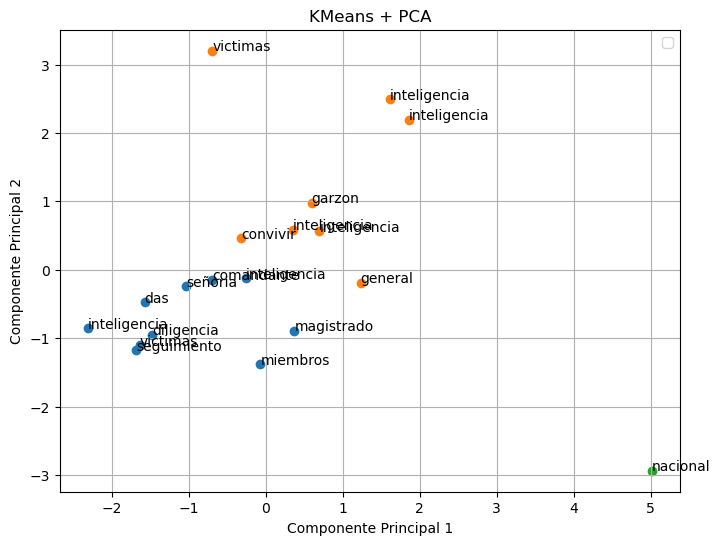

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# seleccionamos solo las que son numericas
df_caso_6_numericas = df_caso_6.select_dtypes(include=[np.number])
df_caso_6_numericas
# seleccionamos solo las que son string
df_caso_6_string = df_caso_6[['Nodo con Mayor Betweenness']]

X = df_caso_6_numericas
y = df_caso_6_string['Nodo con Mayor Betweenness']

# Escalar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)  # Puedes cambiar el número de componentes según tu necesidad
X_pca = pca.fit_transform(X_scaled)

# Realizar KMeans
kmeans = KMeans(n_clusters=3)  # Puedes ajustar el número de clusters según tu necesidad
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Crear un nuevo DataFrame con las componentes principales, las etiquetas de KMeans y los nombres
pca_df = pd.DataFrame(data=X_pca, columns=['Componente 1', 'Componente 2'])
pca_df['nombre'] = y
pca_df['cluster'] = labels

# Graficar los resultados
plt.figure(figsize=(8, 6))
for cluster in pca_df['cluster'].unique():
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(subset['Componente 1'], subset['Componente 2'], label=None)
    for i, punto in subset.iterrows():
        plt.text(punto['Componente 1'], punto['Componente 2'], punto['nombre'])

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('KMeans + PCA')
plt.legend()
plt.grid(True)
plt.savefig('../output/taller4_plot/caso_6/pca_kmeans_caso_6.png')
plt.show()

c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\bcriv\miniconda3\envs\semillero\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


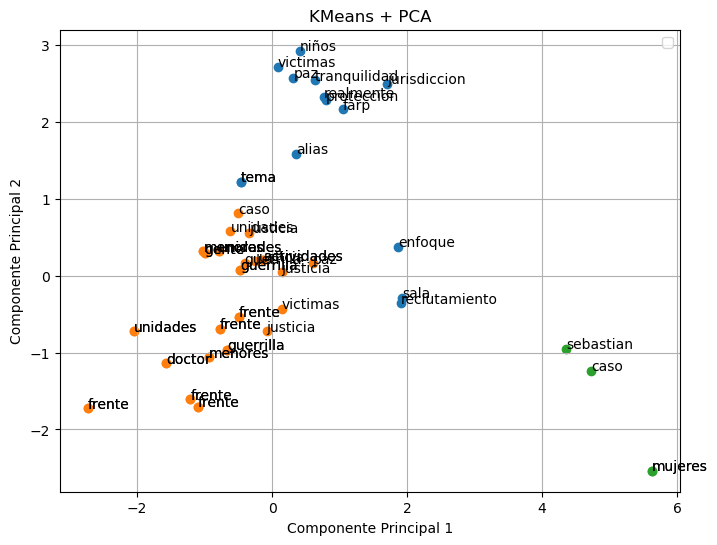

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# seleccionamos solo las que son numericas
df_caso_7_numericas = df_caso_7.select_dtypes(include=[np.number])
df_caso_7_numericas
# seleccionamos solo las que son string
df_caso_7_string = df_caso_7[['Nodo con Mayor Betweenness']]

X = df_caso_7_numericas
y = df_caso_7_string['Nodo con Mayor Betweenness']

# Escalar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)  # Puedes cambiar el número de componentes según tu necesidad
X_pca = pca.fit_transform(X_scaled)

# Realizar KMeans
kmeans = KMeans(n_clusters=3)  # Puedes ajustar el número de clusters según tu necesidad
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Crear un nuevo DataFrame con las componentes principales, las etiquetas de KMeans y los nombres
pca_df = pd.DataFrame(data=X_pca, columns=['Componente 1', 'Componente 2'])
pca_df['nombre'] = y
pca_df['cluster'] = labels

# Graficar los resultados
plt.figure(figsize=(8, 6))
for cluster in pca_df['cluster'].unique():
    subset = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(subset['Componente 1'], subset['Componente 2'], label=None)
    for i, punto in subset.iterrows():
        plt.text(punto['Componente 1'], punto['Componente 2'], punto['nombre'])

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('KMeans + PCA')
plt.legend()
plt.grid(True)
# guardar imagen
plt.savefig('../output/taller4_plot/caso_7/kmeans_pca.png')
plt.show()
